# 1 Planejamento do experimento

In [1]:
import numpy as np
from statsmodels.stats.power import NormalIndPower

In [26]:
# Níveis de confiança e significância (alpha)
confidence_level = 0.95
alpha = 1-confidence_level
power = 0.8
beta = 1-power

In [27]:
# Taxas de conversão
p1 = 0.13
p2 = 0.15

# Tamanho do efeito: Cohen's h
effect_size = 2*(np.arcsin(np.sqrt(p1))-np.arcsin(np.sqrt(p2)))
effect_size

-0.0576728617308947

In [28]:
sample_size = NormalIndPower().solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power
)
sample_size = int(np.ceil(sample_size))
sample_size

4720

# 2 Descrição dos dados

## Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats

In [2]:
%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df2 = pd.read_csv('../data/raw/ab_data.csv')

## 2.1 Renomear colunas

In [4]:
df2.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

## 2.2 Dimensão dos dados

In [5]:
print('Número de linhas: ', df2.shape[0])
print('Número de colunas: ', df2.shape[1])

Número de linhas:  294478
Número de colunas:  5


## 2.3 Tratar os NAs

In [6]:
df2.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## 2.4 Tipo dos dados

In [7]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [8]:
df2.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

# 3 Preparação dos dados

In [9]:
df3 = df2.copy()

## 3.1 Usuários com flags erradas

In [10]:
aux = df3[['user_id','landing_page']].groupby('user_id').nunique().reset_index()
aux.sort_values('landing_page', ascending=False, inplace=True)
aux.head()

,user_id,landing_page
57236,692249,2
256285,908753,2
197289,844575,2
39756,673239,2
120359,760840,2


In [11]:
bad_users = aux.loc[aux['landing_page'] > 1, 'user_id'].to_list()
print(f'{len(bad_users)} usuários visitaram ambas as páginas')

1998 usuários visitaram ambas as páginas


In [12]:
df3.drop(df3[df3['user_id'].isin(bad_users)].index, inplace=True)

In [13]:
aux = df3[['user_id', 'group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()
aux.pivot(index='group', columns='landing_page', values='user_id')

landing_page,new_page,old_page
group,,
control,921,144267
treatment,144320,974


In [14]:
df3.drop(df3[(df3['group'] == 'control') & (df3['landing_page'] == 'new_page')].index, inplace=True)
df3.drop(df3[(df3['group'] == 'treatment') & (df3['landing_page'] == 'old_page')].index, inplace=True)

In [15]:
aux = df3[['user_id', 'group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()
aux.pivot(index='group', columns='landing_page', values='user_id')

landing_page,new_page,old_page
group,,
control,NaN,144267.0
treatment,144320.0,NaN


In [16]:
x = (1-df3.shape[0]/df2.shape[0])*100
print('{:.1f}% dos dados excluídos'.format(x))

2.0% dos dados excluídos


## 3.2 Tamanho dos grupos

treatment    0.500092
control      0.499908
Name: group, dtype: float64

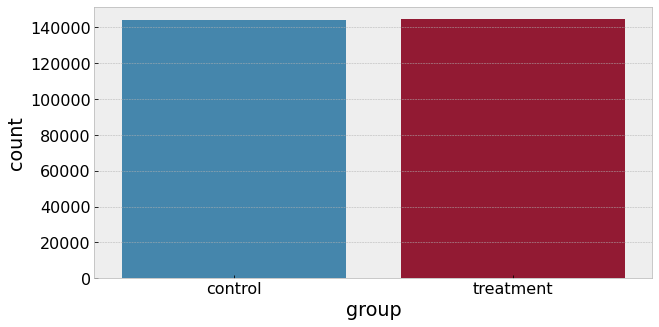

In [17]:
sns.countplot(data=df3, x='group')
df3['group'].value_counts(normalize=True)

# 4 Avaliação dos dados

In [18]:
df4 = df3.copy()

## 4.1 Hipóteses

- H0: os grupos controle e tratamento possuem a mesma taxa de conversão.
- H1: os grupos controle e tratamento possuem taxas de conversão diferentes.

## 4.2 Parâmetros do experimento

In [19]:
alpha = 0.05

## 4.3 Amostragem

In [20]:
sample_size = 4720

In [21]:
df_control = df4[df4['group'] == 'control'].sample(sample_size, random_state=73)
df_treatment = df4[df4['group'] == 'treatment'].sample(sample_size, random_state=73)

In [22]:
df_sample = pd.concat([df_control, df_treatment])

In [23]:
aux = df_sample[['user_id', 'group', 'converted']].groupby(['group', 'converted']).count().reset_index()
df_contingency = aux.pivot(index='group', columns='converted', values='user_id')
df_contingency

converted,0,1
group,,
control,4177,543
treatment,4171,549


## 4.4 Taxas de conversão

In [24]:
conv_rate_control = df_control['converted'].mean()
print('Conversão do grupo controle: {:.2f}%'.format(100*conv_rate_control))

Conversão do grupo controle: 11.50%


In [25]:
conv_rate_treatment = df_treatment['converted'].mean()
print('Conversão do grupo tratamento: {:.2f}%'.format(100*conv_rate_treatment))

Conversão do grupo tratamento: 11.63%


## 4.5 Teste de hipóteses

In [26]:
chi2, pvalue, dof, expected = stats.chi2_contingency(df_contingency)

print(f'p-valor: {pvalue}')
if pvalue <= alpha:
    print('Rejeitar hipótese nula.')
else:
    print('Falha em rejeitar hipótese nula.')

p-valor: 0.8721729157372394
Falha em rejeitar hipótese nula.
